In [1]:
# setup chunk

## import libraries
import torch
import torch.nn as nn
import os
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import random
import math

## set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Import the CNN Model
In order to work with our trained CNN model we first need to set up the exact same architecture with which it was trained and then import the weights we save after training the model. In this version the model also returns the final feature maps just before they get passed to they get flattened and passed to the regression part of the model.

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Overall CNN model architecture
class CNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNN, self).__init__()
        self.in_channels = 32

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Stacked layers of basic block with increasing number of filters
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        # Average pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        feature_maps = self.layer4(x)
        x = self.avg_pool(feature_maps)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x, feature_maps


cnn_model = CNN(BasicBlock, [3, 4, 6, 3]).to(device)
model_weights_path = "/kaggle/input/deeplearningproject/data_analysis/data_analysis/cnn_model_weights.pth"
cnn_model.load_state_dict(torch.load(model_weights_path, map_location=torch.device(device)))

<All keys matched successfully>

### Visualization on Training Data
The following code visualizes some of the final feature maps which the CNN model generates for images of the Oxford dataset. This illustrates how the model actually deals with the input and learned how to effectively count people. We apply the hot color mapping to indicate which pixel values have a high score and which got a low one.

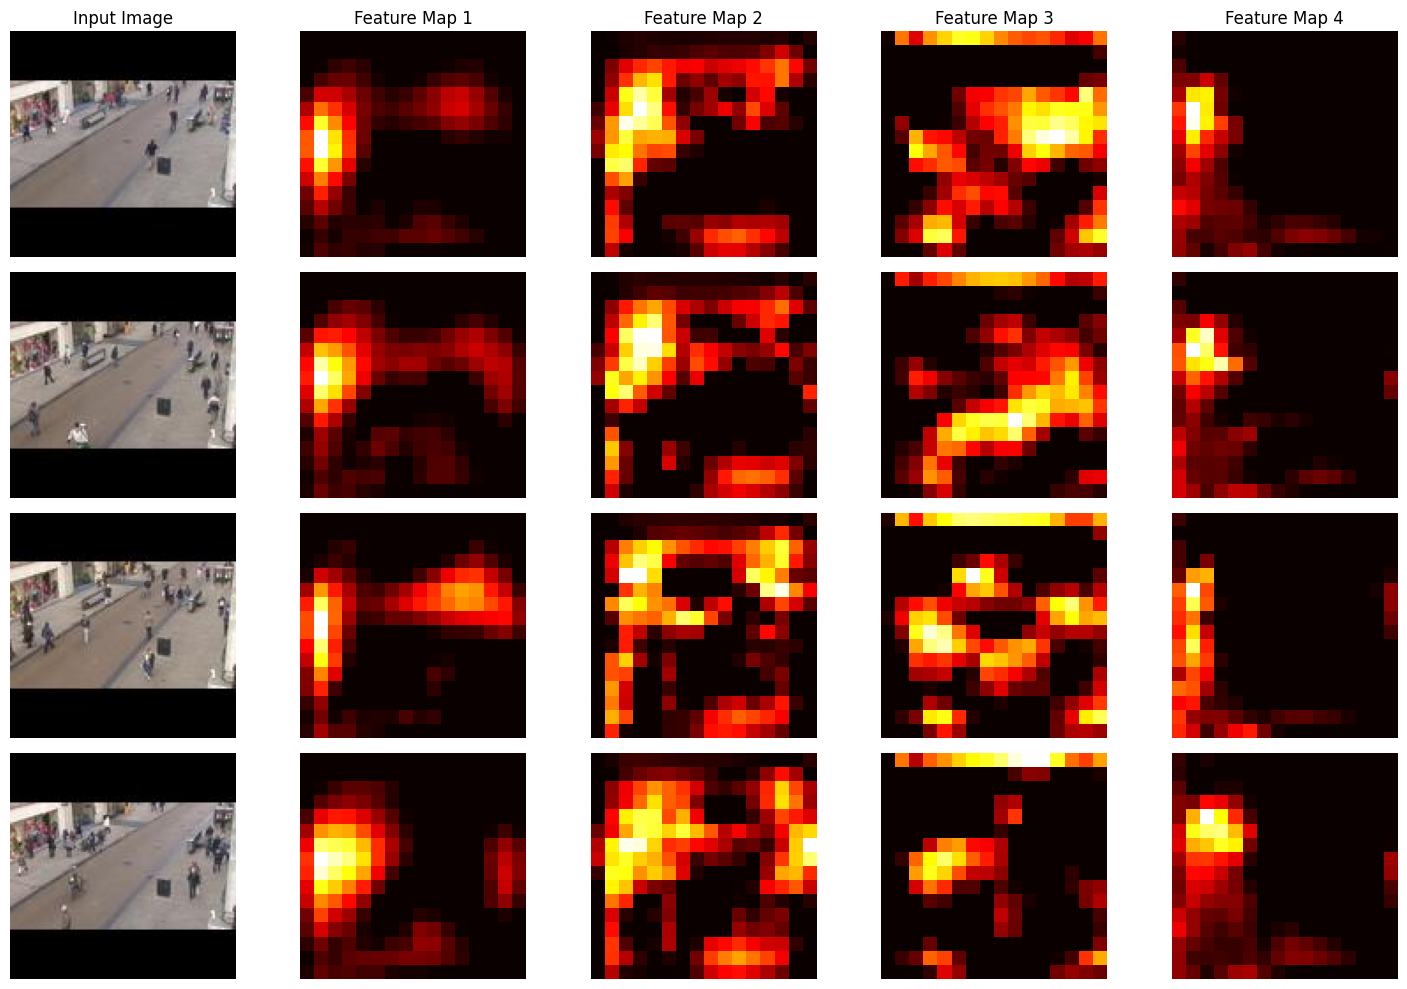

In [10]:
# set the path in which oxford images are stored
folder_paths_training = {
    'Oxford': '/kaggle/input/deeplearningproject/data_model/data_model/oxford_imgs'
}

# define image preprocessing steps
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

def visualize_features_and_inputs(model, num_images=5, num_maps=5):
    model.eval()  # set the model to evaluation mode

    all_image_files = [] # create empty list in which image files get stored
    for training_set, image_dir in folder_paths_training.items():
        # loop through all files and append the filenames to list
        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):
                all_image_files.append((training_set, os.path.join(image_dir, filename)))

    # randomly sample the specified number of images
    selected_images = random.sample(all_image_files, num_images)

    fig, axes = plt.subplots(num_images, num_maps + 1, figsize=(15, 2.5 * num_images))
    
    # loop through the selected images and visualize the actual image and the feature maps
    for idx, (training_set, image_path) in enumerate(selected_images):
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device) # apply preprocessing

        # pass the image through the model to get the output and feature maps
        with torch.no_grad():
            _, feature_maps = model(image_tensor) # extract the feature maps
        feature_maps = feature_maps.cpu().data  # move feature maps to CPU for visualization

        # convert the input image tensor back to numpy for visualization
        image_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        # undo normalization for the visualization
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) 

        # display the input image
        axes[idx, 0].imshow(image_np)
        axes[idx, 0].set_title('Input Image' if idx == 0 else '')
        axes[idx, 0].axis('off')

        # display feature maps
        for i in range(num_maps):
            if i < feature_maps.size(1): 
                fmap = feature_maps[0, i]  # extract feature map for the current image
                # normalize the feature map to [0, 1] range
                fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min())
                axes[idx, i + 1].imshow(fmap.numpy(), cmap='hot', vmin=0, vmax=1) # set the ranges for the color mapping
                axes[idx, i + 1].set_title(f'Feature Map {i+1}' if idx == 0 else '') # set the title
                axes[idx, i + 1].axis('off')
            else:
                axes[idx, i + 1].axis('off')
    plt.tight_layout()
    plt.show()

visualize_features_and_inputs(cnn_model, num_images=4, num_maps=4)

### Visualization on Earthcam Images
In the following we do the same with the Earthcam Images to see how the CNN model deals with this entirely new data.

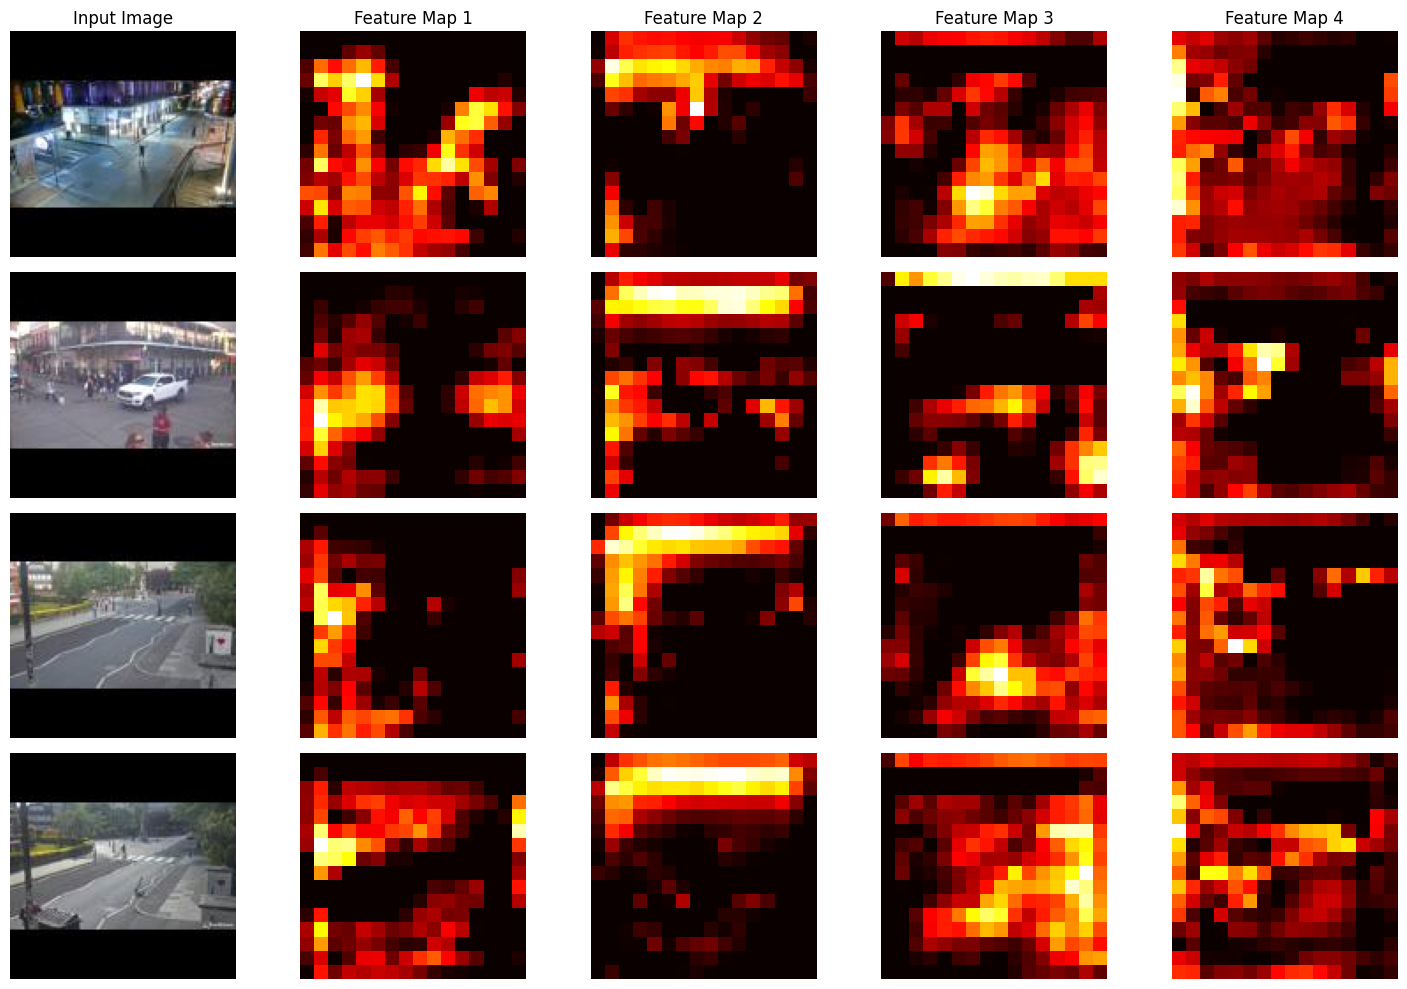

In [9]:
folder_paths_cities = {
    'New York': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Filtered_Images/NewYork_filtered',
    'New Orleans': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Filtered_Images/NewOrleans_filtered',
    'London': '/kaggle/input/deeplearningproject/data_analysis/data_analysis/Filtered_Images/London_filtered'
}

# define image preprocessing steps
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

def visualize_features_and_inputs(model, num_images=5, num_maps=5):
    model.eval()  # set the model to evaluation mode

    all_image_files = [] # create empty list in which image files get stored
    for training_set, image_dir in folder_paths_cities.items():
        # loop through all files and append the filenames to list
        for filename in os.listdir(image_dir):
            if filename.endswith(".jpg"):
                all_image_files.append((training_set, os.path.join(image_dir, filename)))

    # randomly sample the specified number of images
    selected_images = random.sample(all_image_files, num_images)

    fig, axes = plt.subplots(num_images, num_maps + 1, figsize=(15, 2.5 * num_images))
    
    # loop through the selected images and visualize the actual image and the feature maps
    for idx, (training_set, image_path) in enumerate(selected_images):
        image = Image.open(image_path).convert('RGB')
        image_tensor = preprocess(image).unsqueeze(0).to(device) # apply preprocessing

        # pass the image through the model to get the output and feature maps
        with torch.no_grad():
            _, feature_maps = model(image_tensor) # extract the feature maps
        feature_maps = feature_maps.cpu().data  # move feature maps to CPU for visualization

        # convert the input image tensor back to numpy for visualization
        image_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        # undo normalization for the visualization
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) 

        # display the input image
        axes[idx, 0].imshow(image_np)
        axes[idx, 0].set_title('Input Image' if idx == 0 else '')
        axes[idx, 0].axis('off')

        # display feature maps
        for i in range(num_maps):
            if i < feature_maps.size(1): 
                fmap = feature_maps[0, i]  # extract feature map for the current image
                # normalize the feature map to [0, 1] range
                fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min())
                axes[idx, i + 1].imshow(fmap.numpy(), cmap='hot', vmin=0, vmax=1) # set the ranges for the color mapping
                axes[idx, i + 1].set_title(f'Feature Map {i+1}' if idx == 0 else '') # set the title
                axes[idx, i + 1].axis('off')
            else:
                axes[idx, i + 1].axis('off')
    plt.tight_layout()
    plt.show()

visualize_features_and_inputs(cnn_model, num_images=4, num_maps=4)